<a href="https://colab.research.google.com/github/garvit26/Option_Pricing_using_monte_carlo/blob/main/Option_pricing_using_monte_carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

class Ticker:
    @staticmethod
    def get_historical_data(ticker, start_date=None, end_date=None):
        try:
            if start_date is None:
                start_date = datetime.datetime.now() - datetime.timedelta(days=365)
            if end_date is None:
                end_date = datetime.datetime.now()

            stock = yf.Ticker(ticker)
            data = stock.history(start=start_date, end=end_date)

            if data.empty:
                raise ValueError(f"No data returned for ticker {ticker}")
            return data
        except Exception as e:
            raise Exception(f"Error fetching data for ticker {ticker}: {str(e)}")

    @staticmethod
    def get_columns(data):
        if not isinstance(data, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")
        return list(data.columns)

    @staticmethod
    def get_last_price(data, column_name):
        if not isinstance(data, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")
        if column_name not in data.columns:
            raise ValueError(f"Column '{column_name}' not found in the DataFrame")
        return data[column_name].iloc[-1]

    @staticmethod
    def plot_data(data, ticker, column_name):
        if not isinstance(data, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")
        if column_name not in data.columns:
            raise ValueError(f"Column '{column_name}' not found in the DataFrame")

        plt.figure(figsize=(10, 6))
        data[column_name].plot()
        plt.ylabel(column_name)
        plt.xlabel('Date')
        plt.title(f'Historical data for {ticker} - {column_name}')
        plt.legend(loc='best')
        return plt

In [2]:
from enum import Enum
from abc import ABC, abstractmethod

class OPTION_TYPE(Enum):
    CALL_OPTION = 'Call Option'
    PUT_OPTION = 'Put Option'

class OptionPricingModel(ABC):
    """Abstract class defining interface for option pricing models."""

    def calculate_option_price(self, option_type):
        """Calculates call/put option price according to the specified parameter."""
        if option_type == OPTION_TYPE.CALL_OPTION.value:
            return self._calculate_call_option_price()
        elif option_type == OPTION_TYPE.PUT_OPTION.value:
            return self._calculate_put_option_price()
        else:
            return -1

    @classmethod
    @abstractmethod
    def _calculate_call_option_price(cls):
        """Calculates option price for call option."""
        pass

    @classmethod
    @abstractmethod
    def _calculate_put_option_price(cls):
        """Calculates option price for put option."""
        pass

In [7]:
# Third party imports
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt



class MonteCarloPricing(OptionPricingModel):
    """
    Class implementing calculation for European option price using Monte Carlo Simulation.
    We simulate underlying asset price on expiry date using random stochastic process - Brownian motion.
    For the simulation generated prices at maturity, we calculate and sum up their payoffs, average them and discount the final value.
    That value represents option price
    """

    def __init__(self, underlying_spot_price, strike_price, days_to_maturity, risk_free_rate, sigma, number_of_simulations):
        """
        Initializes variables used in Black-Scholes formula .

        underlying_spot_price: current stock or other underlying spot price
        strike_price: strike price for option cotract
        days_to_maturity: option contract maturity/exercise date
        risk_free_rate: returns on risk-free assets (assumed to be constant until expiry date)
        sigma: volatility of the underlying asset (standard deviation of asset's log returns)
        number_of_simulations: number of potential random underlying price movements
        """
        # Parameters for Brownian process
        self.S_0 = underlying_spot_price
        self.K = strike_price
        self.T = days_to_maturity / 365
        self.r = risk_free_rate
        self.sigma = sigma

        # Parameters for simulation
        self.N = number_of_simulations
        self.num_of_steps = days_to_maturity
        self.dt = self.T / self.num_of_steps

    def simulate_prices(self):
        """
        Simulating price movement of underlying prices using Brownian random process.
        Saving random results.
        """
        np.random.seed(20)
        self.simulation_results = None

        # Initializing price movements for simulation: rows as time index and columns as different random price movements.
        S = np.zeros((self.num_of_steps, self.N))
        # Starting value for all price movements is the current spot price
        S[0] = self.S_0

        for t in range(1, self.num_of_steps):
            # Random values to simulate Brownian motion (Gaussian distibution)
            Z = np.random.standard_normal(self.N)
            # Updating prices for next point in time
            S[t] = S[t - 1] * np.exp((self.r - 0.5 * self.sigma ** 2) * self.dt + (self.sigma * np.sqrt(self.dt) * Z))

        self.simulation_results_S = S

    def _calculate_call_option_price(self):
        """
        Call option price calculation. Calculating payoffs for simulated prices at expiry date, summing up, averiging them and discounting.
        Call option payoff (it's exercised only if the price at expiry date is higher than a strike price): max(S_t - K, 0)
        """
        if self.simulation_results_S is None:
            return -1
        return np.exp(-self.r * self.T) * 1 / self.N * np.sum(np.maximum(self.simulation_results_S[-1] - self.K, 0))


    def _calculate_put_option_price(self):
        """
        Put option price calculation. Calculating payoffs for simulated prices at expiry date, summing up, averiging them and discounting.
        Put option payoff (it's exercised only if the price at expiry date is lower than a strike price): max(K - S_t, 0)
        """
        if self.simulation_results_S is None:
            return -1
        return np.exp(-self.r * self.T) * 1 / self.N * np.sum(np.maximum(self.K - self.simulation_results_S[-1], 0))


    def plot_simulation_results(self, num_of_movements):
        """Plots specified number of simulated price movements."""
        plt.figure(figsize=(12,8))
        plt.plot(self.simulation_results_S[:,0:num_of_movements])
        plt.axhline(self.K, c='k', xmin=0, xmax=self.num_of_steps, label='Strike Price')
        plt.xlim([0, self.num_of_steps])
        plt.ylabel('Simulated price movements')
        plt.xlabel('Days in future')
        plt.title(f'First {num_of_movements}/{self.N} Random Price Movements')
        plt.legend(loc='best')
        plt.show()

    def get_calculation_steps(self):
        steps = {
            "Input Parameters": {
                "Spot Price": self.S,
                "Strike Price": self.K,
                "Time to Maturity (days)": self.T,
                "Risk-free Rate": self.r,
                "Volatility": self.sigma
            },
            "Intermediate Calculations": {
                "d1": self.d1,
                "d2": self.d2,
                "N(d1)": self.N_d1,
                "N(d2)": self.N_d2,
                "N(-d1)": self.N_minus_d1,
                "N(-d2)": self.N_minus_d2
            },
            "Final Calculations": {
                "Call Option Price": self.call_price,
                "Put Option Price": self.put_price
            }
        }
        return steps

['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
408.9200134277344


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

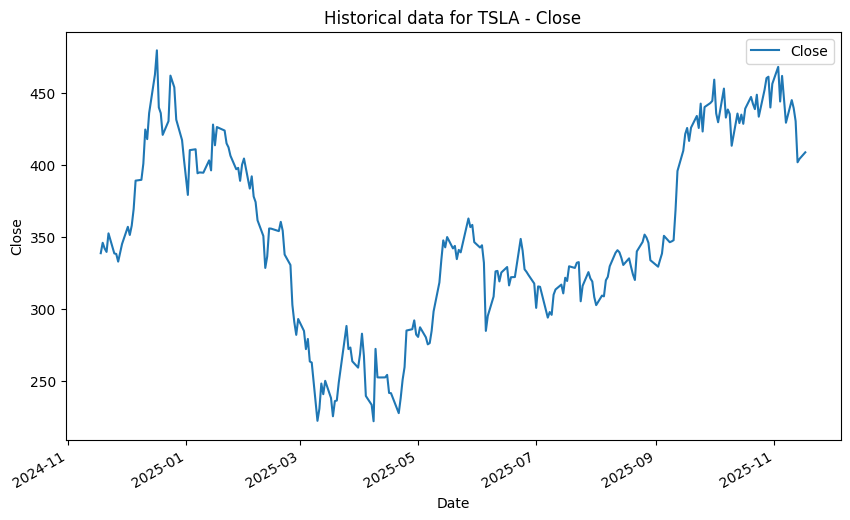

In [9]:
data = Ticker.get_historical_data('TSLA')
print(Ticker.get_columns(data))
print(Ticker.get_last_price(data, 'Close'))
Ticker.plot_data(data, 'TSLA', 'Close')

Call Option:
13.236523688028278
Put Option:
3.6794534443074256


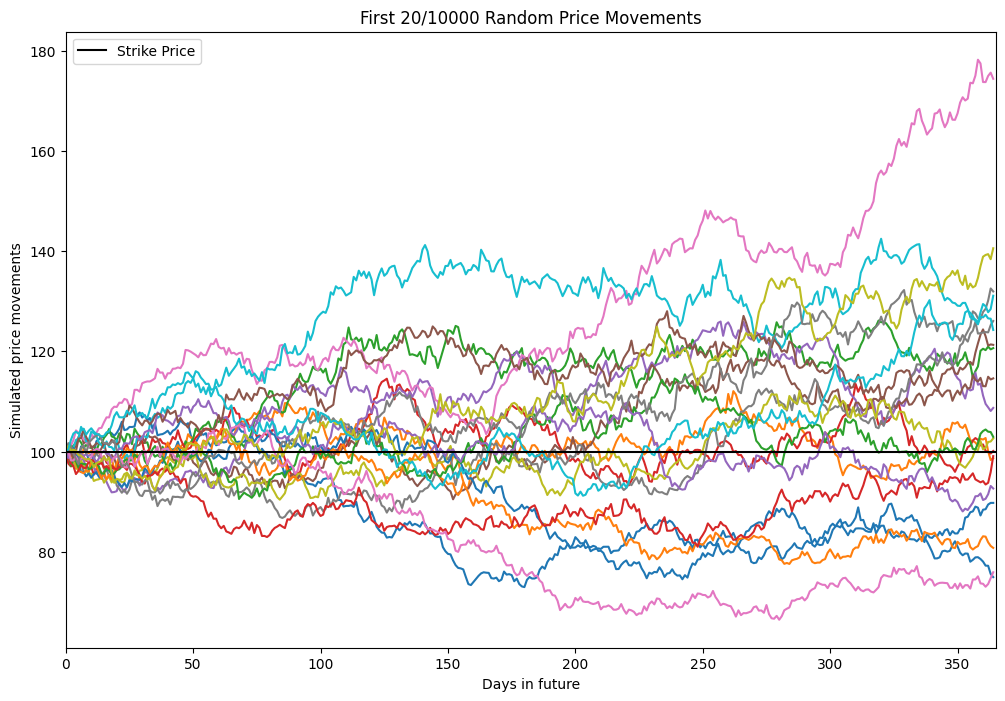

In [11]:

MC = MonteCarloPricing(100, 100, 365, 0.1, 0.2, 10000)
MC.simulate_prices()
print("Call Option:")
print(MC.calculate_option_price('Call Option'))
print("Put Option:")
print(MC.calculate_option_price('Put Option'))
MC.plot_simulation_results(20)